# 📊 Association Rules với FP-Growth

---

## Giới thiệu bài toán

Bài toán **luật kết hợp** (Association Rules) dùng để tìm mối liên hệ giữa các sản phẩm trong dữ liệu giao dịch.

## Thuật toán FP-Growth

- Tìm các **frequent itemsets** (tập mục thường xuyên).
- Nhanh hơn Apriori vì dùng **FP-Tree**.

## Quy trình

1. Chuẩn bị dữ liệu giao dịch.
2. One-Hot Encoding.
3. Chạy FP-Growth.
4. Sinh luật kết hợp.
5. Trực quan hóa luật bằng biểu đồ mạng.


## Cài đặt thư viện cần thiết


In [33]:
# !pip install mlxtend networkx

## Tạo dữ liệu giao dịch mẫu và One-Hot Encoding


In [34]:
import pandas as pd

dataset = [
    ["Milk", "Bread", "Eggs"],
    ["Milk", "Bread"],
    ["Milk", "Eggs"],
    ["Bread", "Eggs"],
    ["Milk", "Bread", "Eggs", "Butter"],
    ["Bread", "Butter"],
    ["Milk", "Butter"],
    ["Eggs", "Butter"],
]

all_items = sorted(set(sum(dataset, [])))
df = pd.DataFrame(
    [{item: (item in transaction) for item in all_items} for transaction in dataset]
)

df

,Bread,Butter,Eggs,Milk
0,True,False,True,True
1,True,False,False,True
2,False,False,True,True
3,True,False,True,False
4,True,True,True,True
5,True,True,False,False
6,False,True,False,True
7,False,True,True,False


## FP-Growth - Tìm Frequent Itemsets

- Giảm `min_support` xuống 0.2 để có nhiều luật hơn.


In [35]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets.sort_values("support", ascending=False, inplace=True)

frequent_itemsets

,support,itemsets
0,0.625,(Milk)
1,0.625,(Eggs)
2,0.625,(Bread)
3,0.500,(Butter)
4,0.375,"(Milk, Eggs)"
5,0.375,"(Eggs, Bread)"
6,0.375,"(Milk, Bread)"
7,0.250,"(Milk, Eggs, Bread)"
8,0.250,"(Butter, Bread)"
9,0.250,"(Eggs, Butter)"


## Tạo Association Rules

- Sử dụng `metric='confidence'` và `min_threshold=0.5` để dễ tạo luật hơn.


In [36]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.sort_values("lift", ascending=False, inplace=True)

rules[["antecedents", "consequents", "support", "confidence", "lift"]]

,antecedents,consequents,support,confidence,lift
6,"(Milk, Eggs)",(Bread),0.250,0.666667,1.066667
8,"(Eggs, Bread)",(Milk),0.250,0.666667,1.066667
7,"(Milk, Bread)",(Eggs),0.250,0.666667,1.066667
0,(Milk),(Eggs),0.375,0.600000,0.960000
3,(Bread),(Eggs),0.375,0.600000,0.960000
2,(Eggs),(Bread),0.375,0.600000,0.960000
1,(Eggs),(Milk),0.375,0.600000,0.960000
5,(Bread),(Milk),0.375,0.600000,0.960000
4,(Milk),(Bread),0.375,0.600000,0.960000
9,(Butter),(Bread),0.250,0.500000,0.800000


## Trực quan hóa luật kết hợp bằng biểu đồ mạng

- Mỗi sản phẩm là một nút.
- Mũi tên từ antecedent → consequent.
- Màu sắc dựa trên lift.


In [37]:
import matplotlib.cm as cm

# Chuẩn hóa lift về [0,1]
lifts = [d["weight"] for (_, _, d) in G.edges(data=True)]
norm = plt.Normalize(min(lifts), max(lifts))
colors_map = cm.plasma(norm(lifts))

fig, ax = plt.subplots(figsize=(8, 6))

# Vẽ nút
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=2000, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", ax=ax)

# Vẽ cạnh
nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="-|>",
    arrowsize=20,
    width=[w * 1.5 for w in lifts],
    edge_color=colors_map,
    ax=ax,
)

# Nhãn cạnh (lift)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)

# Thanh màu
sm = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Lift")

ax.set_title("Biểu đồ mạng luật kết hợp (FP-Growth)", fontsize=14, fontweight="bold")
ax.axis("off")
plt.show()

KeyError: 'weight'

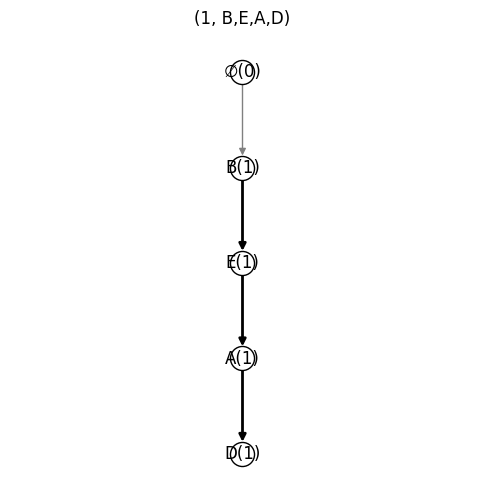

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from IPython.display import HTML
import matplotlib.animation as animation

# ===== DỮ LIỆU =====
transactions = [
    ["B", "E", "A", "D"],
    ["B", "E", "C"],
    ["B", "E", "A", "D"],
    ["B", "E", "A", "C"],
    ["B", "E", "A", "C", "D"],
    ["B", "C", "D"],
]

min_sup = 3

# Tần suất toàn bộ dataset
item_counts = Counter()
for trans in transactions:
    item_counts.update(trans)
sorted_items = [item for item, _ in item_counts.most_common()]


class FPNode:
    def __init__(self, name, count=1):
        self.name = name
        self.count = count
        self.children = {}

    def add(self, items):
        if not items:
            return []
        path_edges = []
        first = items[0]
        if first in self.children:
            self.children[first].count += 1
        else:
            self.children[first] = FPNode(first)
        path_edges.append(
            (self.name + f"({self.count})", first + f"({self.children[first].count})")
        )
        path_edges.extend(self.children[first].add(items[1:]))
        return path_edges


def build_graph(node, graph, parent=None):
    for child in node.children.values():
        graph.add_node(child.name + f"({child.count})")
        if parent:
            graph.add_edge(parent, child.name + f"({child.count})")
        build_graph(child, graph, child.name + f"({child.count})")


def hierarchy_pos(G, root, width=1.0, vert_gap=0.3, vert_loc=0):
    pos = {}

    def _hierarchy_pos(G, root, left, right, vert_loc, pos):
        pos[root] = ((left + right) / 2, vert_loc)
        children = list(G.successors(root))
        if children:
            dx = (right - left) / len(children)
            nextx = left
            for child in children:
                _hierarchy_pos(G, child, nextx, nextx + dx, vert_loc - vert_gap, pos)
                nextx += dx

    _hierarchy_pos(G, root, 0, width, vert_loc, pos)
    return pos


# ===== XÂY CÂY TỪNG BƯỚC =====
steps_data = []
root = FPNode("∅", 0)

for tid, trans in enumerate(transactions, start=1):
    ordered = [item for item in sorted_items if item in trans]
    root.count += 1
    new_edges = root.add(ordered)
    G = nx.DiGraph()
    G.add_node("∅(0)")
    build_graph(root, G, "∅(0)")
    steps_data.append((tid, trans, G.copy(), new_edges))

# Cây hoàn chỉnh và danh sách node bị prune
final_tree = steps_data[-1][2]
prune_nodes = [
    n
    for n in final_tree.nodes()
    if int(n.split("(")[1].strip(")")) < min_sup and n != "∅(0)"
]

# ===== ANIMATION =====
fig, ax = plt.subplots(figsize=(6, 6))
total_frames = len(steps_data) + 1  # +1 cho bước prune


def update(frame):
    ax.clear()
    if frame < len(steps_data):
        # Bước thêm giao dịch
        tid, trans, G, new_edges = steps_data[frame]
        pos = hierarchy_pos(G, "∅(0)")
        edge_colors = ["black" if e in new_edges else "gray" for e in G.edges()]
        widths = [2 if e in new_edges else 1 for e in G.edges()]
        nx.draw(
            G,
            pos,
            with_labels=True,
            node_color="white",
            edgecolors="black",
            edge_color=edge_colors,
            width=widths,
            ax=ax,
        )
        ax.set_title(f"({tid}, {','.join(trans)})")
    else:
        # Bước prune
        pos = hierarchy_pos(final_tree, "∅(0)")
        nx.draw(
            final_tree,
            pos,
            with_labels=True,
            node_color="white",
            edgecolors="black",
            ax=ax,
        )
        for node in prune_nodes:
            if node in pos:
                x, y = pos[node]
                ax.plot(x, y, marker="x", markersize=20, color="red", mew=3)
        ax.set_title(f"Prune nodes with count < {min_sup}")


ani = animation.FuncAnimation(
    fig, update, frames=total_frames, interval=1200, repeat=False
)
HTML(ani.to_jshtml())

In [ ]:
from itertools import combinations
from collections import defaultdict

# Dataset ban đầu
transactions = [
    ["B", "E", "A", "D"],
    ["B", "E", "C"],
    ["B", "E", "A", "D"],
    ["B", "E", "A", "C"],
    ["B", "E", "A", "C", "D"],
    ["B", "C", "D"],
]

min_sup = 3

# Đếm support thực cho mọi tập con
support_count = defaultdict(int)
for trans in transactions:
    for r in range(1, len(trans) + 1):
        for combo in combinations(sorted(trans), r):
            support_count[combo] += 1

# Lọc tập phổ biến
freq_sets = {k: v for k, v in support_count.items() if v >= min_sup}

# Nhóm theo support và in ra như hình
grouped = defaultdict(list)
for items, sup in freq_sets.items():
    grouped[sup].append("".join(items))

for sup in sorted(grouped.keys(), reverse=True):
    print(f"Support = {sup}: {', '.join(sorted(grouped[sup]))}")

Support = 6: B
Support = 5: BE, E
Support = 4: A, AB, ABE, AE, BC, BD, C, D
Support = 3: ABD, ABDE, AD, ADE, BCE, BDE, CE, DE


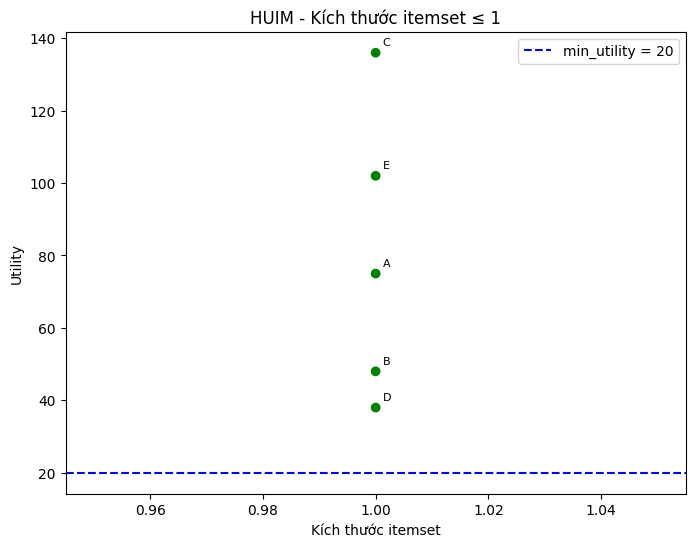

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ===== 1. Tạo dữ liệu giả =====
items = {"A": 5, "B": 3, "C": 8, "D": 2, "E": 6}
transactions = []
for _ in range(20):
    trans = {}
    for item in items:
        if random.random() < 0.5:
            qty = random.randint(1, 3)
            trans[item] = qty
    transactions.append(trans)
df = pd.DataFrame(transactions).fillna(0).astype(int)


# ===== 2. Tính utility cho tất cả itemset =====
def calc_utility(itemset, data, prices):
    total = 0
    for _, row in data.iterrows():
        if all(row[item] > 0 for item in itemset):
            total += sum(row[item] * prices[item] for item in itemset)
    return total


data_points = []
for r in range(1, len(items) + 1):
    for combo in combinations(items.keys(), r):
        util = calc_utility(combo, df, items)
        data_points.append((combo, r, util))

result_df = pd.DataFrame(data_points, columns=["Itemset", "Size", "Utility"])

# ===== 3. Animation theo từng kích thước =====
min_utility = 20
sizes = sorted(result_df["Size"].unique())

fig, ax = plt.subplots(figsize=(8, 6))


def update(frame):
    ax.clear()
    size = sizes[frame]
    subset = result_df[result_df["Size"] <= size].copy()
    subset["HighUtility"] = subset["Utility"] >= min_utility
    colors = subset["HighUtility"].map({True: "green", False: "red"})

    ax.scatter(subset["Size"], subset["Utility"], c=colors)
    ax.axhline(
        y=min_utility,
        color="blue",
        linestyle="--",
        label=f"min_utility = {min_utility}",
    )

    # Annotate các điểm vượt ngưỡng
    for _, row in subset[subset["HighUtility"]].iterrows():
        ax.annotate(
            "".join(row["Itemset"]),
            (row["Size"], row["Utility"]),
            textcoords="offset points",
            xytext=(5, 5),
            fontsize=8,
        )

    ax.set_xlabel("Kích thước itemset")
    ax.set_ylabel("Utility")
    ax.set_title(f"HUIM - Kích thước itemset ≤ {size}")
    ax.legend()


ani = FuncAnimation(fig, update, frames=len(sizes), interval=1500, repeat=False)
HTML(ani.to_jshtml())

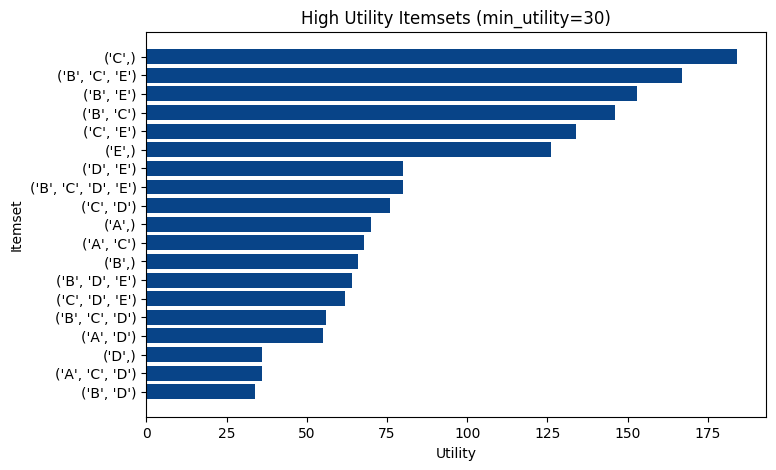

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ===== 1. Tạo dữ liệu giả lập =====
items = {"A": 5, "B": 3, "C": 8, "D": 2, "E": 6}
transactions = []
for _ in range(20):
    trans = {}
    for item in items:
        if random.random() < 0.5:
            qty = random.randint(1, 3)
            trans[item] = qty
    transactions.append(trans)
df = pd.DataFrame(transactions).fillna(0).astype(int)


# ===== 2. Hàm tính utility =====
def calc_utility(itemset, data, prices):
    total = 0
    for _, row in data.iterrows():
        if all(row[item] > 0 for item in itemset):
            total += sum(row[item] * prices[item] for item in itemset)
    return total


# ===== 3. Hàm HUIM với min_utility =====
def huim_results(min_utility):
    results = []
    for r in range(1, len(items) + 1):
        for combo in combinations(items.keys(), r):
            util = calc_utility(combo, df, items)
            if util >= min_utility:
                results.append((combo, util))
    results.sort(key=lambda x: x[1], reverse=True)
    return pd.DataFrame(results, columns=["Itemset", "Utility"])


# ===== 4. Animation =====
fig, ax = plt.subplots(figsize=(8, 5))
min_utils = range(30, 60, 5)  # thay đổi min_utility từ 10 đến 50
colors = plt.cm.Blues_r


def update(frame):
    ax.clear()
    mu = min_utils[frame]
    result_df = huim_results(mu)
    ax.barh(
        result_df["Itemset"].astype(str),
        result_df["Utility"],
        color=colors(len(result_df)),
    )
    ax.set_xlabel("Utility")
    ax.set_ylabel("Itemset")
    ax.set_title(f"High Utility Itemsets (min_utility={mu})")
    ax.invert_yaxis()


ani = FuncAnimation(fig, update, frames=len(min_utils), interval=1500, repeat=False)
HTML(ani.to_jshtml())